In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

# Preprocess data

In [2]:
# Set sampling rate for neurokit2
sampling_rate = 2000

In [3]:
# Cosine interpolation

def cosine(x, x1, x2):
    from math import pi, cos
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def rpeaks_cosine_interpolation(rpeaks):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    rpeaks_cip = [np.nan]*rpeaks_idx[0]

    for i in range(len(rpeaks_idx)):
        if i == len(rpeaks_idx)-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2) # (or def f(x): return cosine(x, x1, x2))
        x = np.linspace(x1, x2, T) # span interval with corresponding number of time steps 
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip
    # keep in mind: there are nans at the start and end

In [4]:
# Preprocess function
def preprocess(datafile, save_path):
    ecg_raw = [None]*len(participants)
    ecg = [None]*len(participants)
    rpeaks = [None]*len(participants)
    data = [None]*len(participants)

    # Load data: raw ecgs for 300 s at 1000 Hz
    ecg_raw = np.load(datafile)

    for i in range(num_participants):
        ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) # .ravel() to remove redundant parentheses
        # Clean and normalize data
        ecg[i] = nk.ecg_clean(
            ecg_raw[i], 
            sampling_rate=sampling_rate, 
            method="neurokit")
        # Get R-peaks as a binary time series
        rpeaks[i] = nk.ecg_peaks(
            ecg[i], 
            sampling_rate=sampling_rate)
        rpeaks[i] = rpeaks[i][0]["ECG_R_Peaks"]
        # Trigonometric interpolation of r-peaks
        data[i] = rpeaks_cosine_interpolation(rpeaks[i])
        # Trim data to get rid of nans
        data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
        # Downsampling to 50 Hz
        data[i] = data[i][::40]
        data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    np.save(f"{save_path}.npy", data)
    return data, ecg, rpeaks

# Quality check
def quality_check(ecg):
    print("###  ECG quality  ###")
    for i in range(num_participants):
        quality = nk.ecg_quality(
            ecg[i], rpeaks=None, 
            sampling_rate=sampling_rate, 
            method="zhao2018", 
            approach="fuzzy")
        print(f"Person {i} | {quality}")

# Pairwise swapping for permutated dyads
def swap_data(data, save_path):
    def swappairwise(a): 
        # Based on https://stackoverflow.com/a/30132333
        l = len(a) & ~1
        a[1:l:2], a[:l:2] = a[:l:2], a[1:l:2]
    # Create new list
    a = list(range(len(data)))
    a.insert(0, a[-1])
    a.pop()
    swappairwise(a) # i.e. 1,2,3,4,5,6 -> 1,6,3,2,5,3,4
    # Iterate through new list
    data_swap = [None]*len(participants)
    for i in list(range(len(data))):
        data_swap[i] = data[a[i]]
        data_swap[i] = np.array(data_swap[i], dtype="float32")
    data_swap = np.array(data_swap)
    # Save files
    np.save(f"{save_path}.npy", data_swap)
    return data_swap

In [5]:
# SIT
data_sit, ecg_sit, rpeaks_sit = preprocess(
    "data/ecg_raw/ecg_raw_sit.npy", 
    "data/data_sit")
quality_check(ecg_sit)
print("Data shape SIT:", data_sit.shape)

###  ECG quality  ###
Person 0 | Excellent
Person 1 | Barely acceptable
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Barely acceptable
Person 7 | Excellent
Data shape SIT: (8, 14800)


In [6]:
# GAZE and GAZE-SWAP
data_gaze, ecg_gaze, rpeaks_gaze = preprocess(
    "data/ecg_raw/ecg_raw_gaze.npy", 
    "data/data_gaze")
data_gaze_swap = swap_data(
    data_gaze, 
    "data/data_gaze_swap")
quality_check(ecg_gaze)
print("Data shape GAZE:     ", data_gaze.shape)
print("Data shape GAZE-SWAP:", data_gaze_swap.shape)

###  ECG quality  ###
Person 0 | Excellent
Person 1 | Excellent
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Excellent
Person 7 | Excellent
Data shape GAZE:      (8, 14800)
Data shape GAZE-SWAP: (8, 14800)


In [7]:
# Sanity check for pariwise swapping
np.equal(
    data_gaze,
    data_gaze_swap)

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

## Plot data

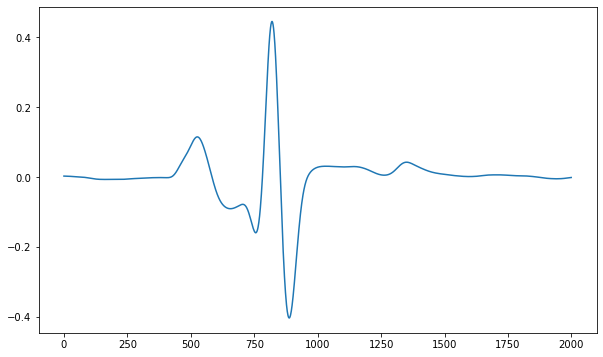

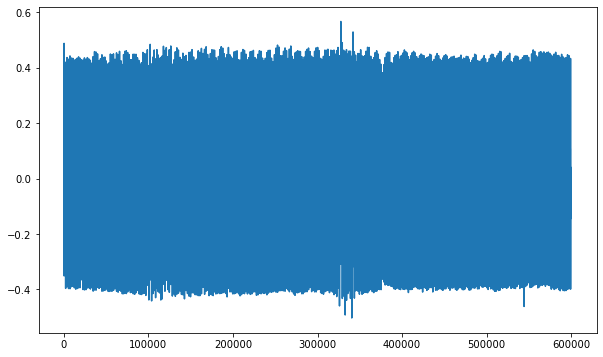

In [8]:
# Show sample data
plt.figure(1)
plt.plot(ecg_sit[0][0:sampling_rate])

plt.figure(2)
plt.plot(ecg_gaze[0])

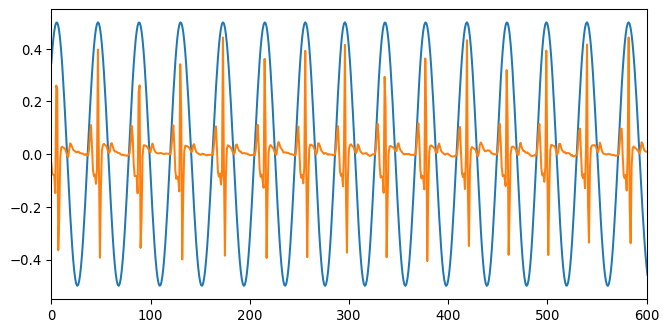

In [9]:
xlim1 = 0*sampling_rate/40
xlim2 = 24*sampling_rate/40

fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2/2)

plt.plot(data_sit[0])
plt.plot(ecg_sit[0][2*sampling_rate::40])

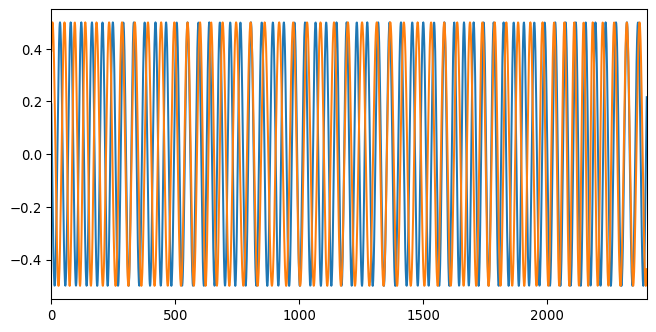

In [10]:
fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2*2)
test = np.array(data_gaze[0])

plt.plot(data_gaze[0])
plt.plot(data_gaze[1])

(200.0, 300.0)

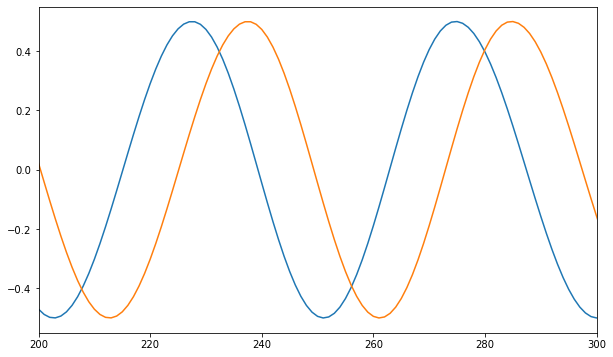

In [16]:
plt.plot(data_sit[1][10:])
plt.plot(data_sit[1][0:])

plt.xlim([200,300])

In [98]:
# Simulate synched data (SYNC)

def rpeaks_cosine_interpolation_with_noise(rpeaks,noise_size=0):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    num_rpeaks = len(rpeaks_idx)
    
    # add noise
    if noise_size == 0: 
        noise = [0]*num_rpeaks
    elif noise_size != 0:
        noise_numbers = list(range(-noise_size,noise_size+1,1))
        repeats = num_rpeaks//len(noise_numbers)
        noise = [[noise_numbers[i]]*repeats for i in noise_numbers]
        noise = np.array(noise).flatten()
        remainder = num_rpeaks % len(noise)
        remainder_add = np.array([0]*remainder)
        noise = np.append(noise,remainder_add)
        np.random.shuffle(noise)

    rpeaks_cip = [np.nan]*(rpeaks_idx[0]+noise[0])
        
    for i in range(num_rpeaks):
        if i == num_rpeaks-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2) # (or def f(x): return cosine(x, x1, x2))
        x = np.linspace(x1, x2, T+noise[i+1]) # span interval with corresponding number of time steps 
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip
    # keep in mind: there are nans at the start and end
    


In [ ]:

    # Trigonometric interpolation of r-peaks
    data[i] = rpeaks_cosine_interpolation(rpeaks[i])
    # Trim data to get rid of nans
    data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
    # Downsampling to 50 Hz
    data[i] = data[i][::40]
    data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    np.save(f"{save_path}.npy", data)
    return data, ecg, rpeaks

In [99]:
a = rpeaks_cosine_interpolation_with_noise(rpeaks_sit[0], noise_size=134)
a = a[::40]

(4400.0, 7000.0)

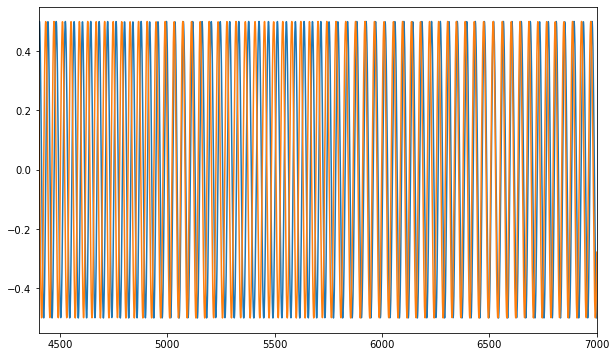

In [100]:
plt.plot(a[100:])
plt.plot(data_sit[0])
plt.xlim([4400,7000])

In [136]:
a=list(range(-noise_size,noise_size+1,10))

-70

In [161]:
# Generate uniform distributed noise with a step and sum = 0

rpeaks_idx = [i for i, x in enumerate(rpeaks_sit[1]) if x == 1]
num_rpeaks = len(rpeaks_idx)

# interval (-/+) of values that act as noise 
noise_size = 100 # 134 -> 3%, 109 -> 2%, 55 -> 1%
noise_range = list(range(-noise_size,noise_size+1,10))
# frequency of every number in the uniform distribution (based on floored float)
repeats = num_rpeaks//len(noise_range)
# first part of the random vector
noise_temp = [[noise_range[i]]*repeats for i,_ in enumerate(noise_range)]
noise_temp = np.array(noise_temp).flatten()

remainder = num_rpeaks % len(noise_temp)
remainder_add = np.array([0]*remainder)
noise = np.append(noise_temp,remainder_add)

np.random.shuffle(noise)
if len(rpeaks_idx) == len(noise):
    print("OK")
print(i,np.mean(abs(noise))/2000, np.std(noise))
print(len(noise))
print(sum(noise))
print(remainder)
print(noise)


OK
130 0.02558139534883721 59.844760412564185
301
0
7
[  30   80  -10 -100 -100   40   80  -80  -60   10  -70   60    0    0
  -40  -30   90   10   30   80 -100  -40  100  100  100   50   30   20
  -80    0  -80  -30  -70  -20   70  -20  -80   80  -30 -100   50    0
  -90   80   50   50  -80  -60   90  -30  100  -90   20   40   10   50
    0    0  -80   70  -40   20    0   80  -50  -50  -70   10   60  -20
   80  -90  -60  -40   40   10  -10   30  -10  -50 -100   20  100   20
   90  -70  -10   10  -90  -30  -60    0   60  -50 -100 -100  -10  -30
   10  -90  -10   80  -30  -40  -30   60   60   70  -40  -50   90  -20
  -30  -80  -90   80  -70  -50  -90   20   30   70  -40   30  -40   70
  -40  -60   90 -100    0    0   70  -60   30   60  -80  -50   40  -40
   30    0    0   60   50   70  -90   50  -30  -70    0   20   40  -70
   10   60  -10   30   60   50  -20  -60  -20   30  -10   10  -60  -10
  -80   10   70  -10   90  -40    0  -20   80   30  -90    0  -10   70
 -100  -70   80   10   

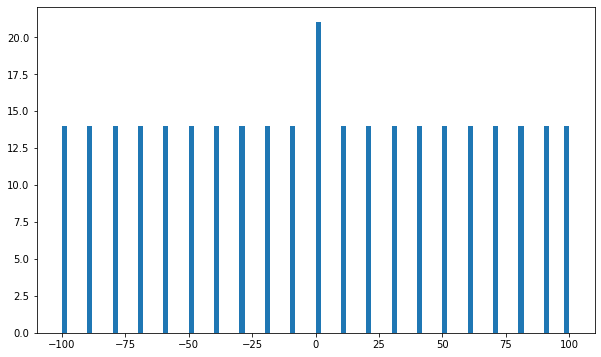

In [155]:
plt.hist(noise,bins=100);

In [102]:
remainder

32

In [157]:
num_rpeaks = remainder

noise_size = remainder//2-1 # 134 -> 3%, 109 -> 2%, 55 -> 1%

noise_range = list(range(-noise_size,noise_size+1,1))
repeats = num_rpeaks//len(noise_range)

noise_temp = [[noise_range[i]]*repeats for i in noise_range]
noise_temp = np.array(noise_temp).flatten()

remainder2 = num_rpeaks % len(noise_temp)
remainder_add = np.array([0]*remainder2)
noise = np.append(noise_temp,remainder_add)

np.random.shuffle(noise)
print(i,np.mean(abs(noise))/2000, np.std(noise))
print(len(noise))
print(sum(noise))
print(noise)

130 0.00042857142857142855 1.1952286093343936
7
0
[ 2  0 -1 -2  0  1  0]


In [107]:
remainder2

1